# Apache Sedona Example Notebook

This notebook demonstrates basic Apache Sedona functionality for spatial data processing.

## Setup and Initialization

In [1]:
from pyspark.sql import SparkSession
from sedona.register import SedonaRegistrator

spark = SparkSession.builder.appName('Test').getOrCreate()
SedonaRegistrator.registerAll(spark)
result = spark.sql('SELECT ST_Point(1.0, 1.0) as point').collect()
print('✅ Sedona works:', result[0]['point'])

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/10/25 11:34:10 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
/tmp/ipykernel_43/3338570753.py:5: DeprecationWarning: Call to deprecated function registerAll (Deprecated since 1.4.1, use SedonaContext.create() instead.).
  SedonaRegistrator.registerAll(spark)


✅ Sedona works: POINT (1 1)


/usr/local/lib/python3.9/dist-packages/sedona/register/geo_registrator.py:45: DeprecationWarning: Call to deprecated function register (Deprecated since 1.4.1, use SedonaContext.create() instead.).
  cls.register(spark)
25/10/25 11:34:13 WARN UDTRegistration: Cannot register UDT for org.locationtech.jts.geom.Geometry, which is already registered.
25/10/25 11:34:13 WARN UDTRegistration: Cannot register UDT for org.locationtech.jts.index.SpatialIndex, which is already registered.
25/10/25 11:34:13 WARN UDTRegistration: Cannot register UDT for org.geotools.coverage.grid.GridCoverage2D, which is already registered.
25/10/25 11:34:13 WARN SimpleFunctionRegistry: The function st_union_aggr replaced a previously registered function.
25/10/25 11:34:13 WARN SimpleFunctionRegistry: The function st_envelope_aggr replaced a previously registered function.
25/10/25 11:34:13 WARN SimpleFunctionRegistry: The function st_intersection_aggr replaced a previously registered function.


In [2]:
from pyspark.sql import SparkSession
from sedona.register import SedonaRegistrator
from sedona.utils import SedonaKryoRegistrator, KryoSerializer
import geopandas as gpd
import matplotlib.pyplot as plt
import folium

In [3]:
# Initialize Spark with Sedona
spark = SparkSession.builder \
    .appName("SedonaExample") \
    .config("spark.serializer", KryoSerializer.getName) \
    .config("spark.kryo.registrator", SedonaKryoRegistrator.getName) \
    .config('spark.jars.packages',
            'org.apache.sedona:sedona-spark-shaded-3.0_2.12:1.4.1,'
            'org.apache.sedona:sedona-viz-3.0_2.12:1.4.1,'
            'org.apache.sedona:sedona-python-adapter-3.0_2.12:1.4.1') \
    .getOrCreate()

# Register Sedona functions
SedonaRegistrator.registerAll(spark)

25/10/25 11:34:21 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.
/tmp/ipykernel_43/544328490.py:13: DeprecationWarning: Call to deprecated function registerAll (Deprecated since 1.4.1, use SedonaContext.create() instead.).
  SedonaRegistrator.registerAll(spark)
/usr/local/lib/python3.9/dist-packages/sedona/register/geo_registrator.py:45: DeprecationWarning: Call to deprecated function register (Deprecated since 1.4.1, use SedonaContext.create() instead.).
  cls.register(spark)
25/10/25 11:34:21 WARN UDTRegistration: Cannot register UDT for org.locationtech.jts.geom.Geometry, which is already registered.
25/10/25 11:34:21 WARN UDTRegistration: Cannot register UDT for org.locationtech.jts.index.SpatialIndex, which is already registered.
25/10/25 11:34:21 WARN UDTRegistration: Cannot register UDT for org.geotools.coverage.grid.GridCoverage2D, which is already registered.
25/10/25 11:34:21 WARN SimpleFunctionRegistry: The function st_u

True

## Troubleshooting

If you encounter `NoClassDefFoundError: org/opengis/referencing/NoSuchAuthorityCodeException`, this means the GeoTools dependencies are missing. 

**Solution:**
1. Rebuild the Docker image with the updated Dockerfile that includes GeoTools JARs
2. Or manually add the required JARs to the Spark classpath

**Manual fix (if needed):**
```bash
# From within the container
wget -P /opt/spark/jars/ https://repo1.maven.org/maven2/org/geotools/gt-referencing/29.2/gt-referencing-29.2.jar
wget -P /opt/spark/jars/ https://repo1.maven.org/maven2/org/geotools/gt-opengis/29.2/gt-opengis-29.2.jar
```

## Creating Spatial Data

In [4]:
# Create sample spatial data
sample_points = spark.sql("""
    SELECT 
        ST_Point(CAST(RAND() * 360 - 180 AS DECIMAL(10,6)), 
                 CAST(RAND() * 180 - 90 AS DECIMAL(10,6))) as geometry,
        CAST(RAND() * 100 AS INT) as value,
        'point_' || CAST(RAND() * 1000 AS INT) as name
    FROM range(100)
""")

sample_points.show(5)

+--------------------+-----+---------+
|            geometry|value|     name|
+--------------------+-----+---------+
|POINT (-60.207214...|   45|point_654|
|POINT (-164.61098...|   54|point_765|
|POINT (80.912018 ...|   17|point_312|
|POINT (162.146541...|    7| point_24|
|POINT (-67.713551...|   85|point_779|
+--------------------+-----+---------+
only showing top 5 rows



## Spatial Operations

In [5]:
# Create a polygon for spatial filtering
bounding_box = spark.sql("""
    SELECT ST_PolygonFromEnvelope(-10.0, -10.0, 10.0, 10.0) as bbox
""")

# Filter points within the bounding box
sample_points.createOrReplaceTempView("points")
bounding_box.createOrReplaceTempView("bbox")

filtered_points = spark.sql("""
    SELECT p.*, ST_X(p.geometry) as longitude, ST_Y(p.geometry) as latitude
    FROM points p, bbox b
    WHERE ST_Within(p.geometry, b.bbox)
""")

print(f"Total points: {sample_points.count()}")
print(f"Points within bounding box: {filtered_points.count()}")
filtered_points.show()

Total points: 100
Points within bounding box: 1
+--------------------+-----+---------+---------+---------+
|            geometry|value|     name|longitude| latitude|
+--------------------+-----+---------+---------+---------+
|POINT (9.011882 -...|    0|point_237| 9.011882|-3.705894|
+--------------------+-----+---------+---------+---------+



## Spatial Analysis

In [6]:
# Calculate distances between points
distance_analysis = spark.sql("""
    SELECT 
        p1.name as point1,
        p2.name as point2,
        ST_Distance(p1.geometry, p2.geometry) as distance
    FROM points p1
    CROSS JOIN points p2
    WHERE p1.name != p2.name
    ORDER BY distance
    LIMIT 10
""")

print("Closest point pairs:")
distance_analysis.show()

Closest point pairs:
+---------+---------+------------------+
|   point1|   point2|          distance|
+---------+---------+------------------+
|point_263|point_959|1.8352817229237575|
|point_959|point_263|1.8352817229237575|
|point_714|point_367|3.2390974849178296|
|point_367|point_714|3.2390974849178296|
|point_294|point_518| 3.634938741949033|
|point_518|point_294| 3.634938741949033|
|point_161|point_571| 5.272422458978121|
|point_571|point_161| 5.272422458978121|
|point_284|point_682| 5.392393221145693|
|point_682|point_284| 5.392393221145693|
+---------+---------+------------------+



## Visualization

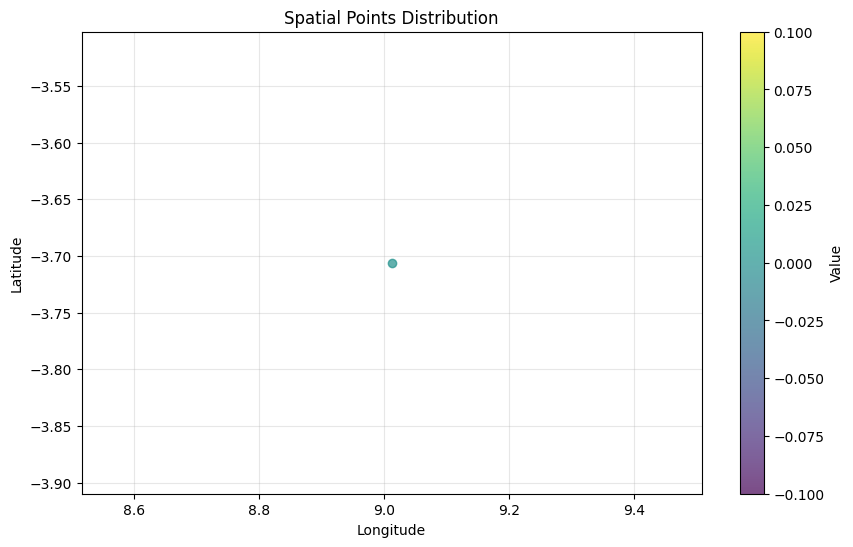

In [7]:
# Convert to pandas for visualization
points_pdf = filtered_points.toPandas()

# Create a simple scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(points_pdf['longitude'], points_pdf['latitude'], 
           c=points_pdf['value'], cmap='viridis', alpha=0.7)
plt.colorbar(label='Value')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Spatial Points Distribution')
plt.grid(True, alpha=0.3)
plt.show()

In [9]:
# Create an interactive map with Folium
if len(points_pdf) > 0:
    center_lat = points_pdf['latitude'].mean()
    center_lon = points_pdf['longitude'].mean()
    
    m = folium.Map(location=[center_lat, center_lon], zoom_start=6)
    
    for idx, row in points_pdf.iterrows():
        folium.CircleMarker(
            location=[row['latitude'], row['longitude']],
            radius=5,
            popup=f"Name: {row['name']}<br>Value: {row['value']}",
            color='red',
            fill=True,
            fillColor='red'
        ).add_to(m)
    
    # Add bounding box
    folium.Rectangle(
        bounds=[[-10, -10], [10, 10]],
        color='blue',
        fill=False,
        popup='Bounding Box'
    ).add_to(m)
    
    m
else:
    print("No points found within the bounding box to display.")

## Cleanup

In [ ]:
# Stop Spark session
spark.stop()